**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import os
import numpy as np
import pickle
import cv2
import glob
import time
import random

from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


In [98]:
def plot_figures(figures, nrows = 1, ncols=1, labels=None, show_axis=False):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 15))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
           axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)

        axs[index].set_axis_off()

    plt.tight_layout()
    
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation    
    
def load_calibration():
    dist_pickle = pickle.load(open('./calibrate.p', "rb"))
    return dist_pickle['mtx'], dist_pickle['dist']

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    #Region of Interest
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    windows = []
    for scale in scales:
        imshape = ctrans_tosearch.shape
        if scale != 1:
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - 1
        nfeat_per_block = orient * cell_per_block ** 2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart), 
                                  (0, 0, 255), 6)
                    windows.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return draw_img, windows

In [99]:
cars = []
non_cars = []

car_files = os.listdir('vehicles/')
non_car_files = os.listdir('non-vehicles/')

for imgtype in car_files:
    cars.extend(glob.glob('vehicles/' + imgtype + '/*'))

for imgtype in non_car_files:
    non_cars.extend(glob.glob('non-vehicles/' + imgtype + '/*'))

print('cars: ', len(cars))
print('non-cars: ', len(non_cars))

cars:  8792
non-cars:  8968


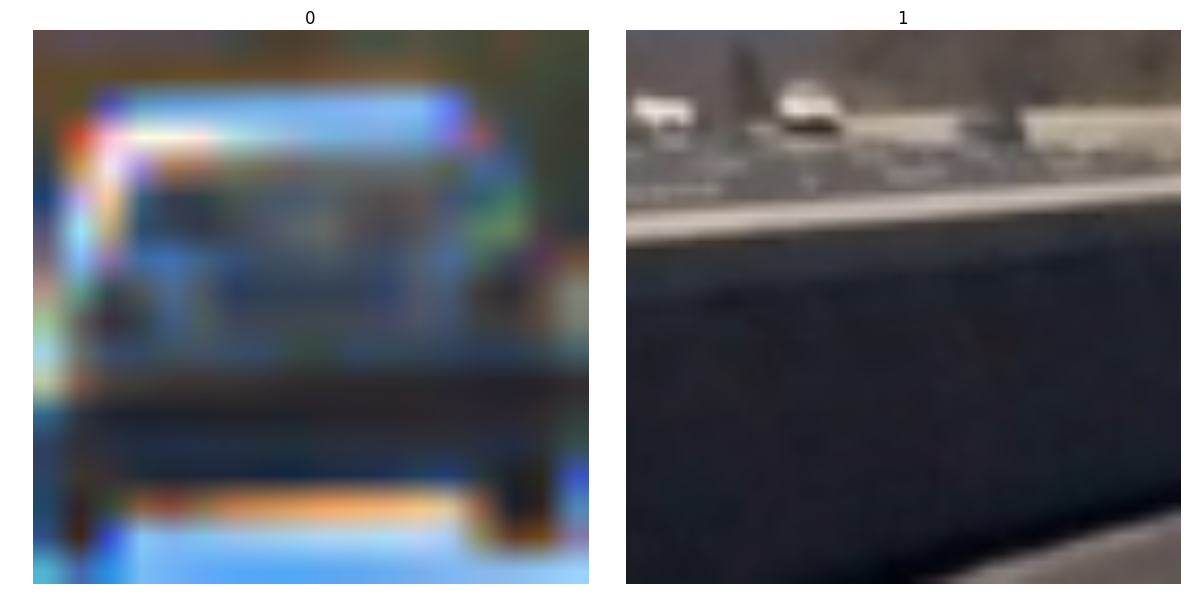

In [100]:
figures = {}

car_i = np.random.randint(0, len(cars))
non_car_i = np.random.randint(0, len(non_cars))

car_image = cv2.imread(cars[car_i])
RGB_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
figures[0] = RGB_car_image

non_car_image = cv2.imread(non_cars[non_car_i])
RGB_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2RGB)
figures[1] = RGB_non_car_image

plot_figures(figures, 1, 2)

This cell above shows an example of the car and non-car images I loaded for use.

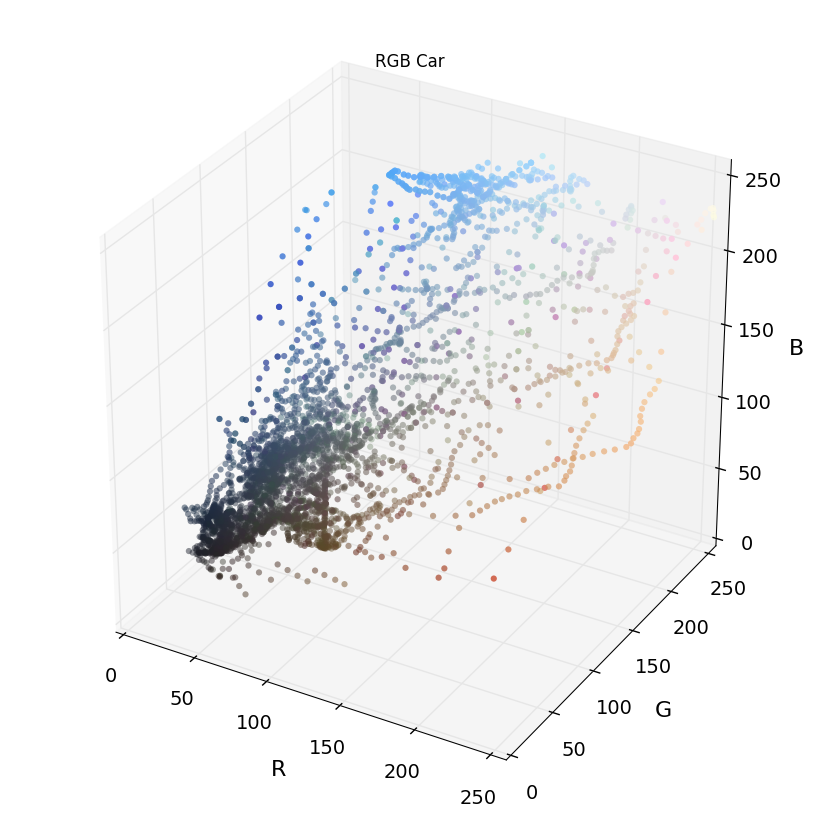

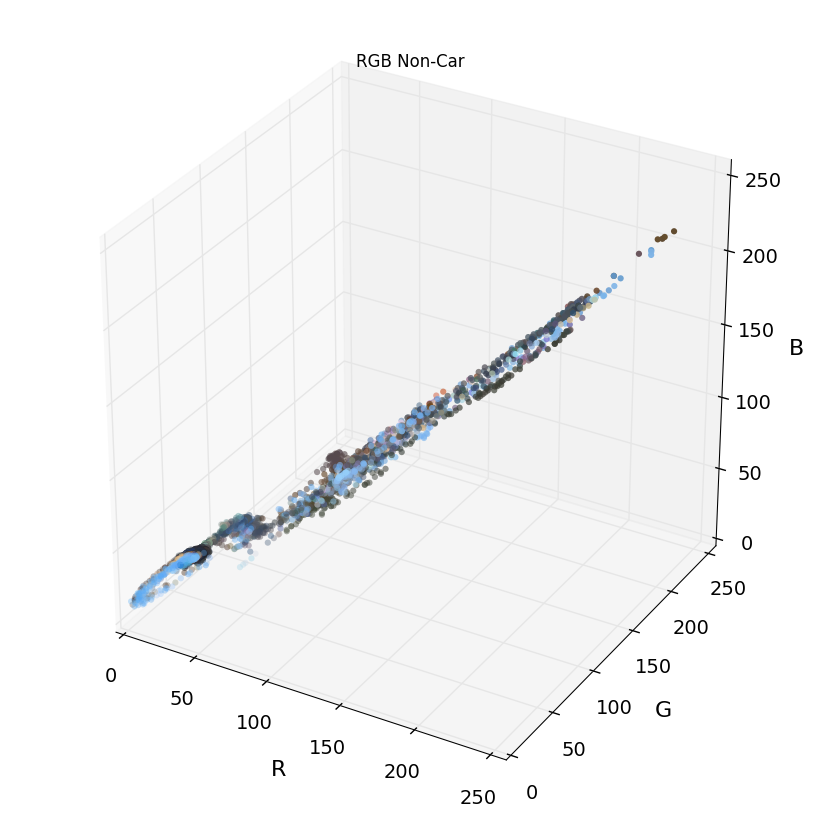

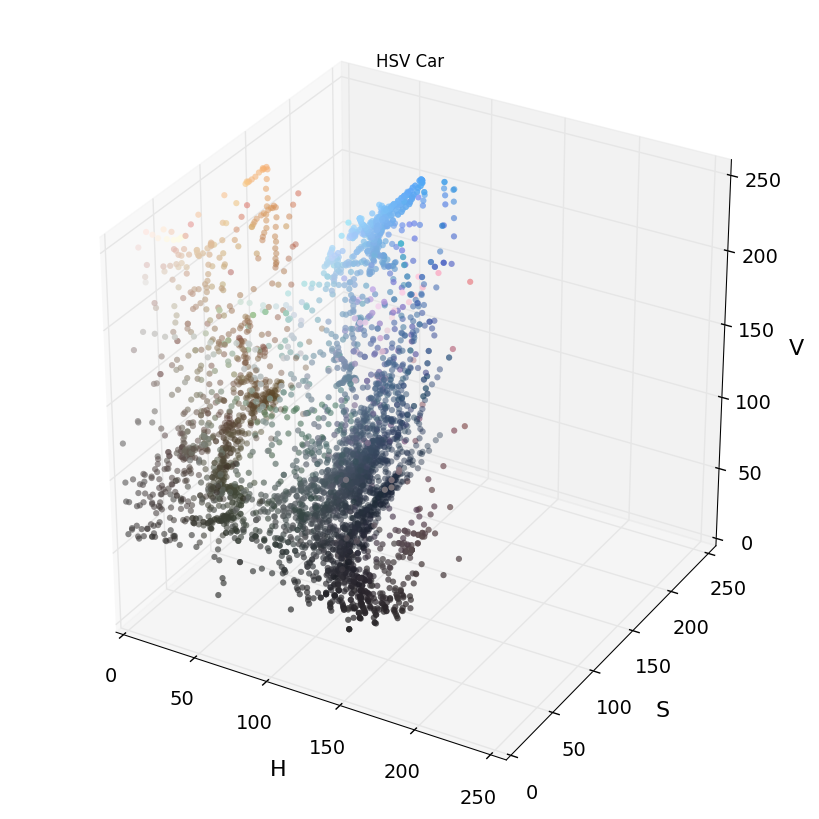

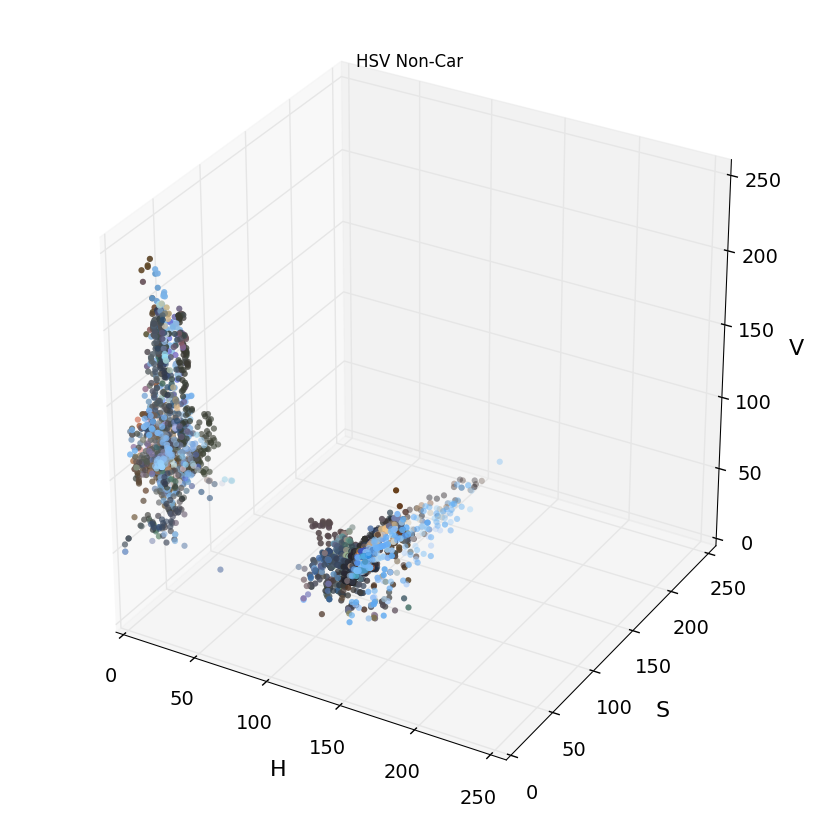

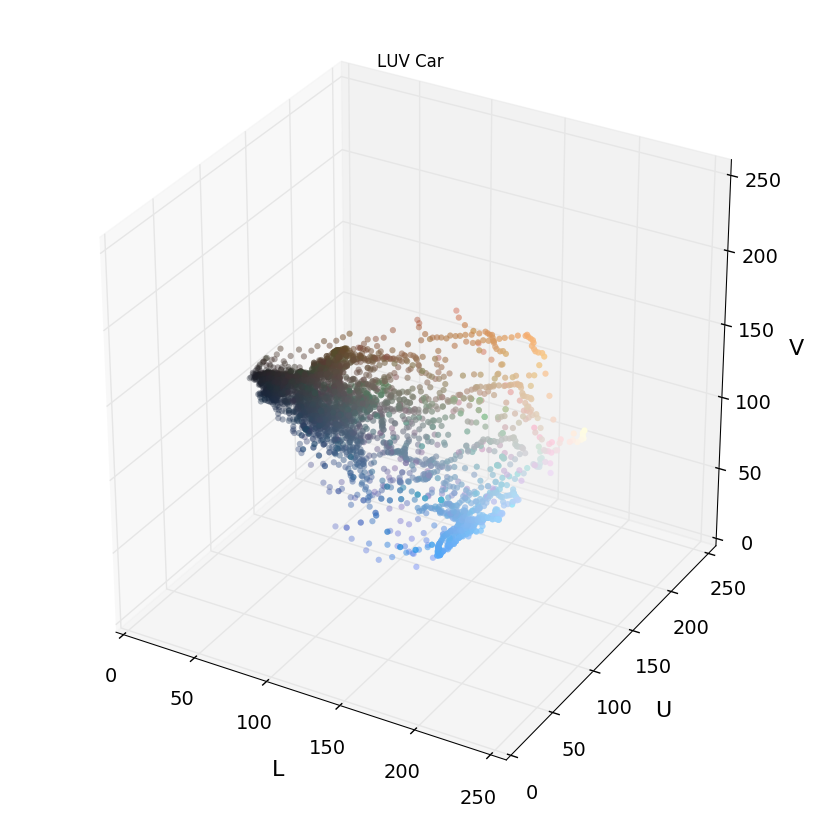

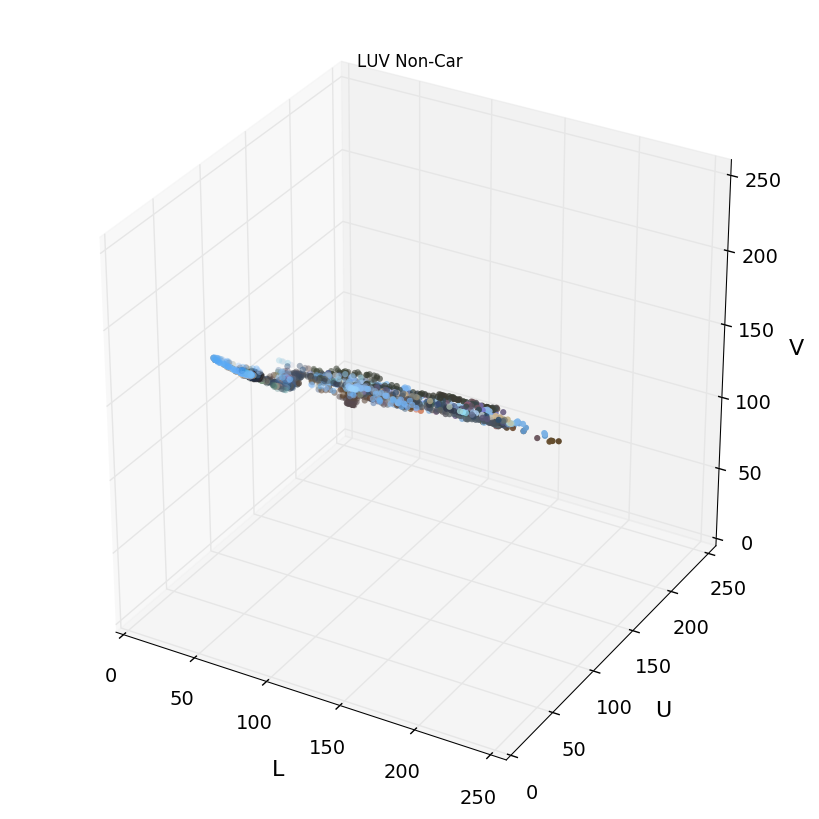

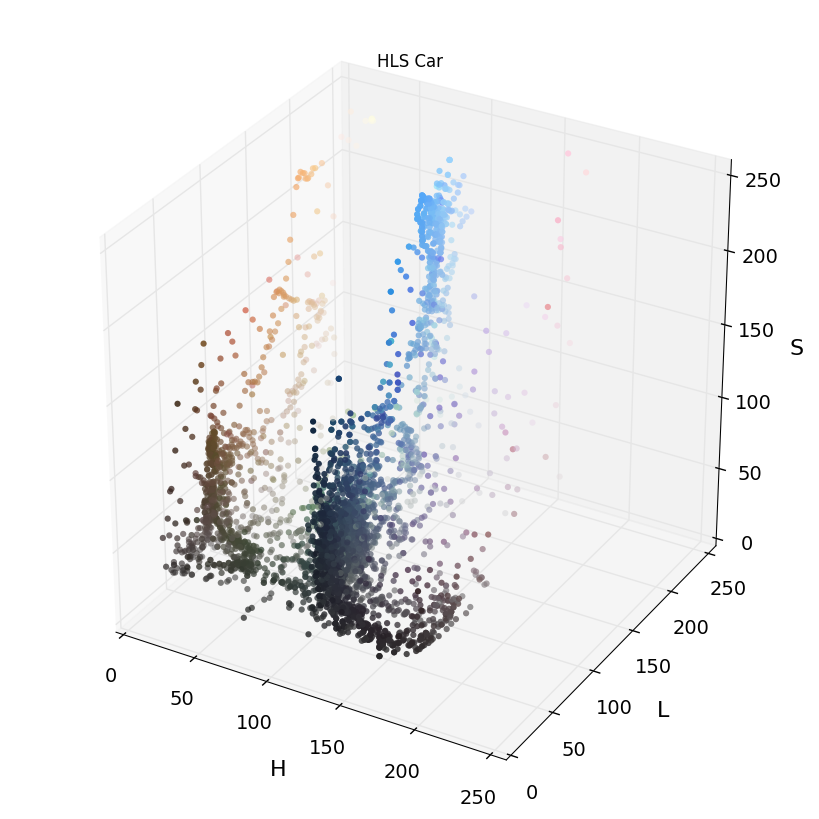

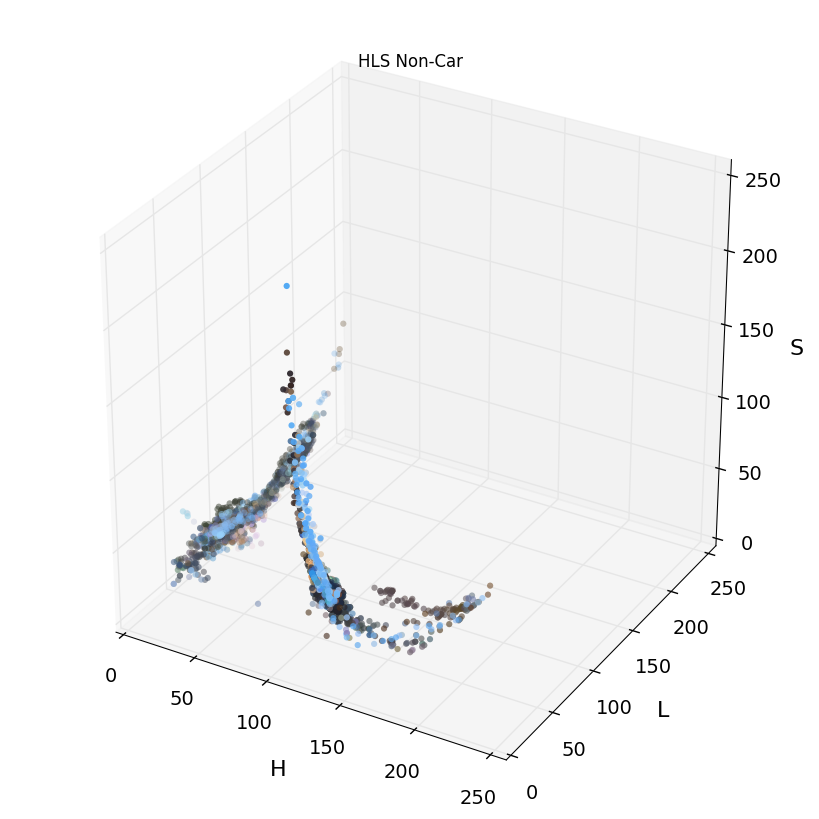

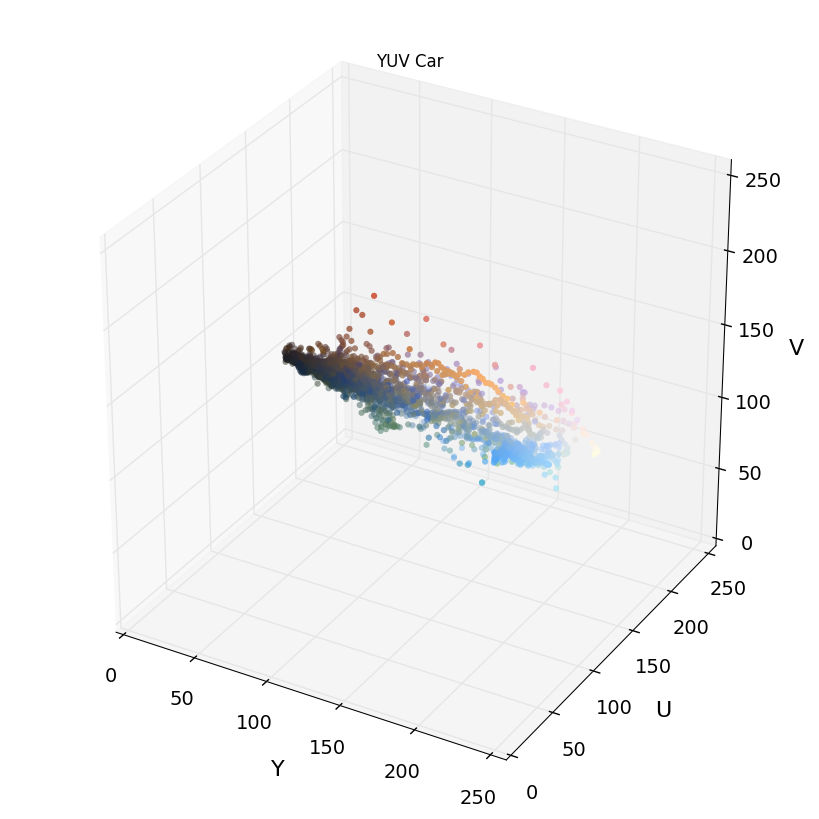

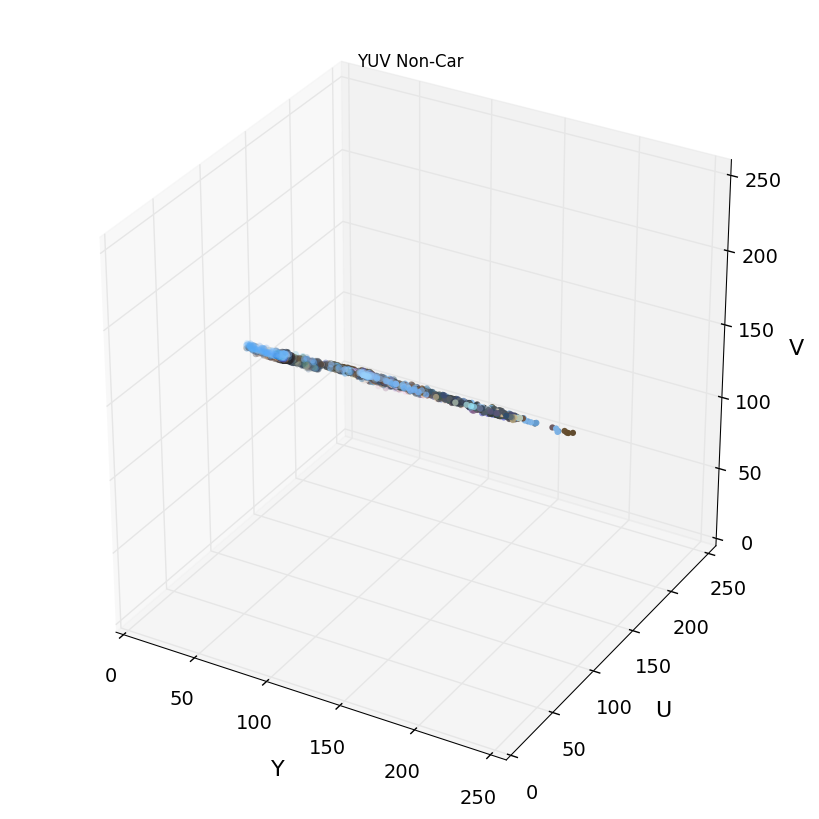

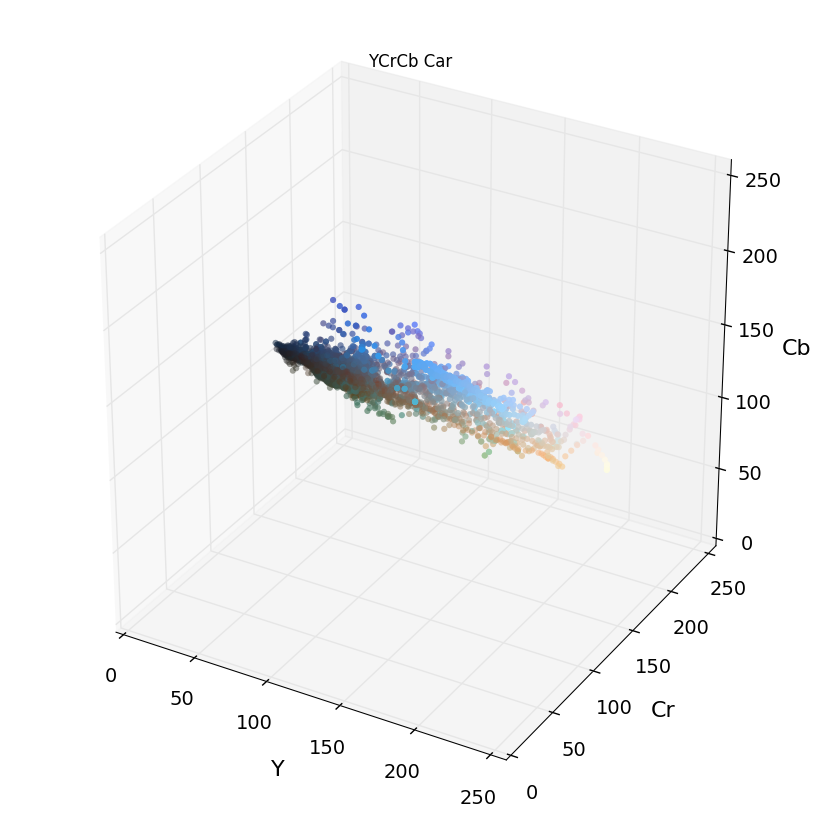

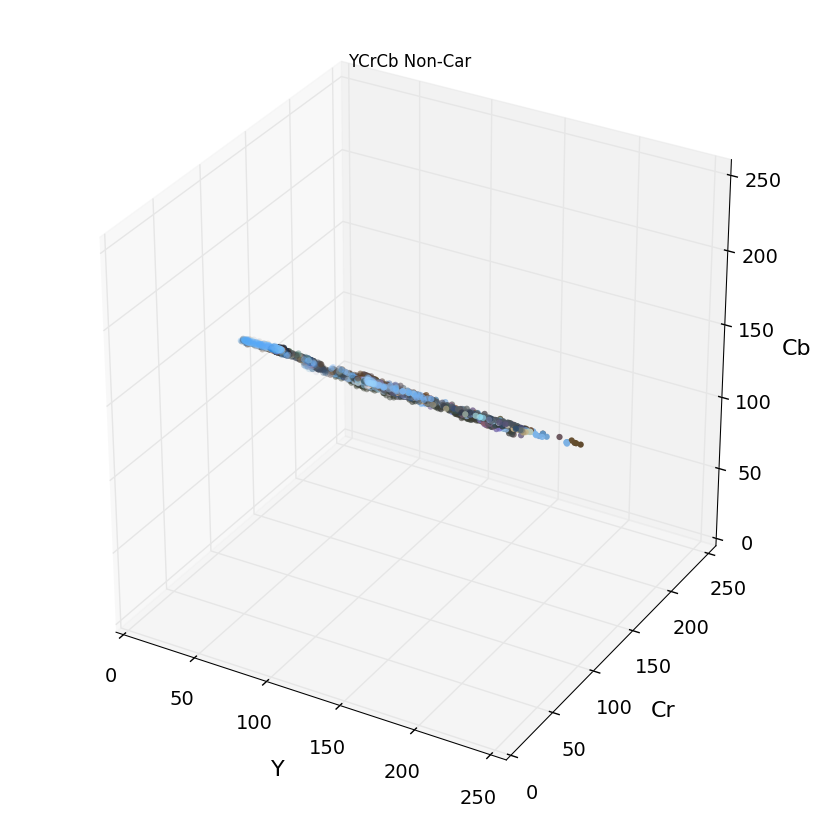

In [101]:
#lets see if we can see any differences in color spaces that might prove useful
rgb_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
rgb_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2RGB)

hsv_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2HSV)
hsv_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2HSV)

luv_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2LUV)
luv_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2LUV)

hls_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2HLS)
hls_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2HLS)

yuv_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2YUV)
yuv_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2YUV)

ycrcb_car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2YCrCb)
ycrcb_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2YCrCb)

rgb_image2 = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)/255.

#lets use the plot3d method from the lessons
plot3d(rgb_car_image, rgb_image2)
plt.title('RGB Car')
plt.show()

plot3d(rgb_non_car_image, rgb_image2)
plt.title('RGB Non-Car')
plt.show()

plot3d(hsv_car_image, rgb_image2, axis_labels=list("HSV"))
plt.title('HSV Car')
plt.show()

plot3d(hsv_non_car_image, rgb_image2, axis_labels=list("HSV"))
plt.title('HSV Non-Car')
plt.show()

plot3d(luv_car_image, rgb_image2, axis_labels=list("LUV"))
plt.title('LUV Car')
plt.show()

plot3d(luv_non_car_image, rgb_image2, axis_labels=list("LUV"))
plt.title('LUV Non-Car')
plt.show()

plot3d(hls_car_image, rgb_image2, axis_labels=list("HLS"))
plt.title('HLS Car')
plt.show()

plot3d(hls_non_car_image, rgb_image2, axis_labels=list("HLS"))
plt.title('HLS Non-Car')
plt.show()

plot3d(yuv_car_image, rgb_image2, axis_labels=list("YUV"))
plt.title('YUV Car')
plt.show()

plot3d(yuv_non_car_image, rgb_image2, axis_labels=list("YUV"))
plt.title('YUV Non-Car')
plt.show()

plot3d(ycrcb_car_image, rgb_image2, axis_labels=['Y', 'Cr', 'Cb'])
plt.title('YCrCb Car')
plt.show()

plot3d(ycrcb_non_car_image, rgb_image2, axis_labels=['Y', 'Cr', 'Cb'])
plt.title('YCrCb Non-Car')
plt.show()

Looks like YCrCb is the most clustered. It may yield better results.

<h1>Histogram of Oriented Gradients (HOG)</h1>

The parameters used below were most effective given time constraints. Tested several, but settled with these.  
color_space = 'YCrCb'

orient = 9

pix_per_cell = 8

cell_per_block = 2


hog_channel = 'ALL'

spatial_size = (16, 16)

hist_bins = 32

To extract the HOG features, I used the hog fucntion from skimage.feature library.

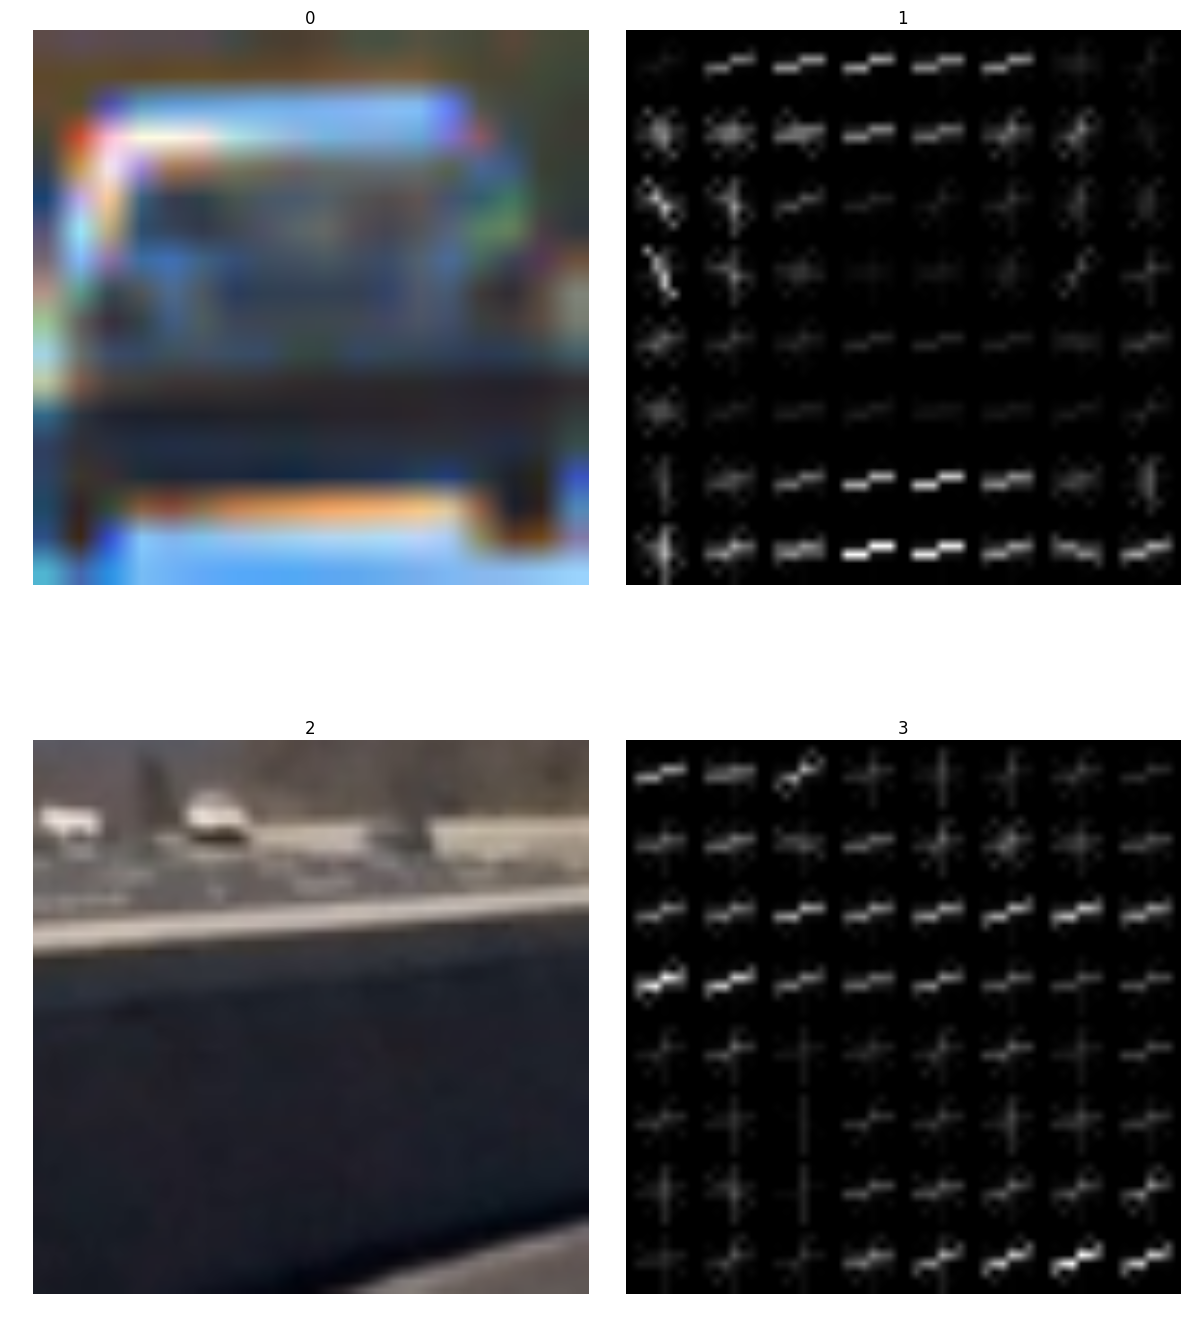

In [102]:
# Define feature parameters
color_space = 'YCrCb'  # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2

hog_channel = 'ALL'  # 0, 1, 2, "ALL"
spatial_size = (16, 16)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

figures = {}

figures[0] = rgb_car_image
hog_features, car_hog_image = get_hog_features(ycrcb_car_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
figures[1] = car_hog_image

figures[2] = rgb_non_car_image
hog_features, non_car_hog_image = get_hog_features(ycrcb_non_car_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
figures[3] = non_car_hog_image

plot_figures(figures, 2, 2)

Here we extra features for car and non-car images and then train our classifier. 

To train the classifier I used Linear SVC.  

In [107]:
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
            hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
            cell_per_block=cell_per_block, hog_channel=hog_channel,
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

non_car_features = extract_features(non_cars, color_space=color_space, spatial_size=spatial_size,
            hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
            cell_per_block=cell_per_block, hog_channel=hog_channel,
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, non_car_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.10, random_state=np.random.randint(0, 100))

print('Using: ', orient, 'orientations, ', pix_per_cell, 'pixels per cell, ', cell_per_block, 'cells per block, ',
      hist_bins, 'histogram bins, and ', spatial_size, 'spatial sampling')
print('Feature vector length: ', len(X_train[0]))

# Linear SVC
# svc = SVC(kernel='rbf')
svc= LinearSVC(C=0.00001)

t = time.time()
svc.fit(X_train, y_train)

print(round(time.time()-t, 2), 'Seconds to train SVC...)')
print('Test Accuracy: ', round(svc.score(X_test, y_test), 4))

Using:  9 orientations,  8 pixels per cell,  2 cells per block,  32 histogram bins, and  (16, 16) spatial sampling
Feature vector length:  6156
3.9 Seconds to train SVC...)
Test Accuracy:  0.987


In order to find the cars I use a sliding window search or multiple convolutions of different sizes.  The scales were 1.5 to 2 to simplify things.  I could of use more, but this seemed good enough to capture the most important cars.  I also defined a region of interst to speed up detection since we don't have to detect any flying cars as of yet.  After that I tried to detect the areas with the most activity.  I did this using the label method from scipy.ndimage.measurements.  It helps calculating points of interests. After that I applied a threshold to set values under a specific amount will be set to zero. 

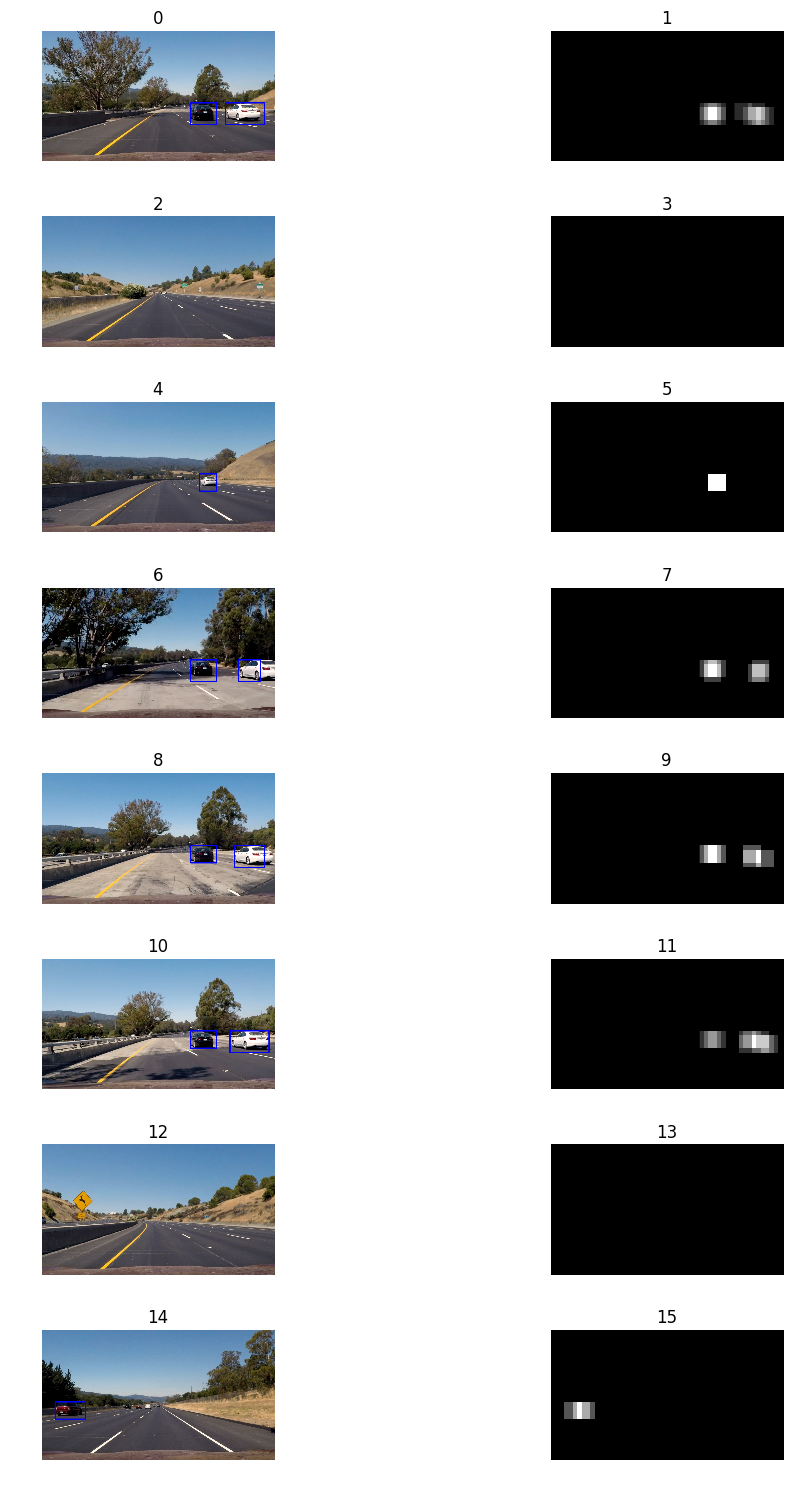

In [109]:
test_images = glob.glob('test_images/*')
y_start_stop = (400, 650)
scales = [1.5, 2]

figures = {}
count = 0
for img in test_images:
    img = cv2.imread(img)
    output_img, windows = find_cars(img, y_start_stop[0], y_start_stop[1], scales, svc, X_scaler, orient,
                                    pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat_map = np.zeros_like(img[:, :, 0])
    heat_map = add_heat(heat_map, windows)
    heat_map = np.clip(heat_map, 0, 255)
    heat_map = apply_threshold(heat_map, 0)
    
    labels = label(heat_map)
    figures[count] = draw_labeled_bboxes(np.copy(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), labels)
    count += 1
    figures[count] = heat_map
    count += 1

plot_figures(figures, 8, 2)

<h1>Video Implementation</h1>

In [105]:
past_frames = []

def process_image(img):
    global past_frames
    
    output_img, windows = find_cars(img, y_start_stop[0], y_start_stop[1], scales, svc, X_scaler, orient,
                                    pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    past_frames.append(windows)
    past_frames = past_frames[-15:]

    heat_map = np.zeros_like(img[:, :, 0])
    heat_map = add_heat(heat_map, [window for windows in past_frames for window in windows])
    heat_map = np.clip(heat_map, 0, 255)
    heat_map = apply_threshold(heat_map, 15)

    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

My output video is can be created and found by name "project2_vid.mp4" It was created using the code below.  Here is a link to the video output : https://youtu.be/_V4ykY_Keb8

In [106]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'project2_vid.mp4'
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project2_vid.mp4
[MoviePy] Writing video project2_vid.mp4


100%|█████████▉| 1260/1261 [10:12<00:00,  2.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project2_vid.mp4 

CPU times: user 18min 19s, sys: 1min 55s, total: 20min 14s
Wall time: 10min 12s


<h1>Discussion</h1>
Ultimately this project showed how to do some basic detection, but I still have noise and false positives I would have to deal with in order to get a better detector.  I think if I stepped through the video frame by frame I could better tune the parameters to give better results.  